This is a simple exercise in time series forecasting.  The ARIMA and Exponential Smoothing models were validated on 12 unseen data points (Oct 2017 ~ Sep 2018).  Forecasts from the models were blended using RMSE as weights. This is then used to generate projections for the next 12 months (Oct 2018 ~ Sep 2019).  Mean absolute percentage error: 2.87%.

<p>Benchmark Prices for Apartment in Greater Vancouver</p>
<p>Source: CREA</p>
<p>Dataset: Jan 2005 ~ Sep 2017</p>
<p>Validation: Oct 2017 ~ Sep 2018</p>
<p>Frequency: Monthly</p>


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/apartment-benchmark-prices/Validation.csv
/kaggle/input/apartment-benchmark-prices/Dataset.csv


In [2]:
import pandas as pd
df=pd.read_csv('/kaggle/input/apartment-benchmark-prices/Dataset.csv',index_col=0,header=0,squeeze=True)
validation=pd.read_csv('/kaggle/input/apartment-benchmark-prices/Validation.csv',index_col=0,header=0,squeeze=True)
print('Dataset %d, Validation %d' %(len(df),len(validation)))

Dataset 153, Validation 12


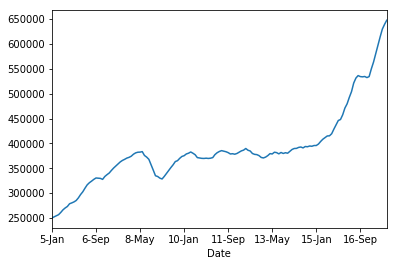

In [3]:
import matplotlib.pyplot as plt
df.plot()

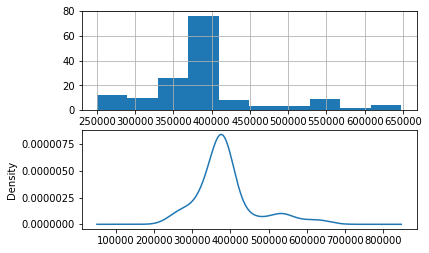

In [4]:
plt.figure()
plt.subplot(211)
df.hist()
plt.subplot(212)
df.plot(kind='kde')
plt.show()

The data shows a trend but no seasonality. Distribution is near Gaussian.  

In [5]:
#Check stationarity
from statsmodels.tsa.stattools import adfuller

result=adfuller(df.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.4f' % (key,value)) 

ADF Statistic: -2.047571
p-value: 0.266112
Critical Values:
	1%: -3.4766
	5%: -2.8818
	10%: -2.5776


Both the p-value and ADF statistic suggests that the first order differentiation isn't sufficient to attain stationarity. 

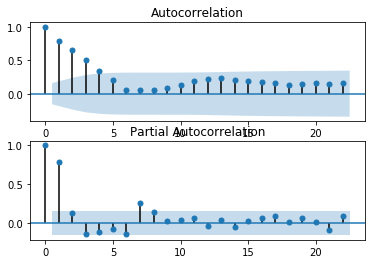

In [6]:
#Plot ACF and PACF for first order differencing

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt 
import numpy as np

plt.figure()
plt.subplot(211)
plot_acf(df.diff().dropna(),ax=plt.gca())
plt.subplot(212)
plot_pacf(df.diff().dropna(),ax=plt.gca())
plt.show()

In [7]:
# Check second order differencing

result=adfuller(df.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.4f' % (key,value)) 

ADF Statistic: -7.502199
p-value: 0.000000
Critical Values:
	1%: -3.4766
	5%: -2.8818
	10%: -2.5776


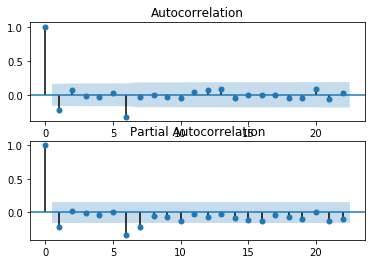

In [8]:
#Plot ACF and PACF for second order differencing

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt 
import numpy as np

plt.figure()
plt.subplot(211)
plot_acf(df.diff().diff().dropna(),ax=plt.gca())
plt.subplot(212)
plot_pacf(df.diff().diff().dropna(),ax=plt.gca())
plt.show()

The second order of differencing attained stationarity.

In [9]:
# Manually configure ARIMA

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
import numpy as np

# Calculate mean absolute percentage error
def mean_abs_percent_error(obs,yhat):
    obs, yhat=np.array(obs),np.array(yhat)
    return np.mean(np.abs((obs-yhat)/obs))*100

# Prepare data
X=df.values
X=X.astype('float32')
train_size=int(len(X)*0.7)
train, test=X[0:train_size], X[train_size:]

# Walk-forward validation
history=[x for x in train]
predictions=list()
for i in range(len(test)):
    #predict
    model=ARIMA(history,order=(1,2,1))
    model_fit=model.fit(disp=0)
    yhat=model_fit.forecast()[0]
    predictions.append(yhat)
    #observation
    obs=test[i]
    history.append(obs)
    print('Predicted= %.4f, Expected= %.4f' % (yhat,obs))

# Report performance
rmse=sqrt(mean_squared_error(test,predictions))
print('RMSE: %.4f' % (rmse))

Predicted= 381712.1139, Expected= 380300.0000
Predicted= 380055.6211, Expected= 384000.0000
Predicted= 386147.8597, Expected= 387800.0000
Predicted= 391621.3498, Expected= 389800.0000
Predicted= 392378.9756, Expected= 390000.0000
Predicted= 390747.5969, Expected= 392000.0000
Predicted= 393422.7937, Expected= 392800.0000
Predicted= 393965.9415, Expected= 391000.0000
Predicted= 389991.1753, Expected= 393800.0000
Predicted= 395108.2883, Expected= 393300.0000
Predicted= 393843.7702, Expected= 394800.0000
Predicted= 395629.0281, Expected= 394300.0000
Predicted= 394450.0931, Expected= 395800.0000
Predicted= 396601.1049, Expected= 395800.0000
Predicted= 396294.0528, Expected= 398800.0000
Predicted= 400748.4910, Expected= 404000.0000
Predicted= 408477.7258, Expected= 408500.0000
Predicted= 413264.0316, Expected= 411800.0000
Predicted= 415524.6838, Expected= 415000.0000
Predicted= 418247.7045, Expected= 415300.0000
Predicted= 416564.7271, Expected= 419500.0000
Predicted= 422361.6058, Expected= 

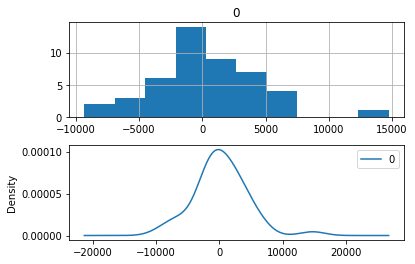

In [10]:
#plot residual errors for ARIMA model
from pandas import DataFrame
#errors
residuals=[test[i]-predictions[i] for i in range(len(test))]
residuals=DataFrame(residuals)
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde',ax=plt.gca())
plt.show()

In [11]:
residuals.describe()

,0
count,46.000000
mean,216.044125
std,4174.243810
min,-9320.125738
25%,-1818.084398
50%,-68.896536
75%,2827.941458
max,14728.964182


In [12]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  150
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1421.433
Method:                       css-mle   S.D. of innovations           3156.114
Date:                Thu, 28 Nov 2019   AIC                           2850.866
Time:                        06:57:31   BIC                           2862.909
Sample:                             2   HQIC                          2855.759
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.0862    212.133      0.264      0.792    -359.687     471.860
ar.L1.D2.y    -0.2854      0.336     -0.849      0.397      -0.944       0.373
ma.L1.D2.y     0.0568      0.350      0.162      0.8

RMSE: 4128.6223, Mean Absolute Percentage Error: 0.6371

Residuals:
                  0
count     46.000000
mean       0.044125
std     4174.243810
min    -9536.125738
25%    -2034.084398
50%     -284.896536
75%     2611.941458
max    14512.964182


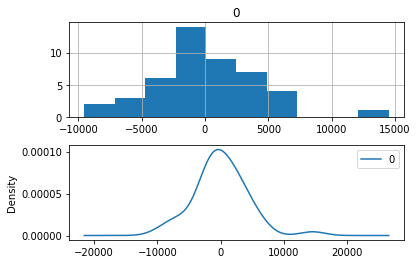

In [13]:
#summarize residual errors from bias corrected forecasts
#walk-forward validation
history=[x for x in train]
predictions=list()
bias=216
for i in range(len(test)):
    #predict
    model=ARIMA(history,order=(1,2,1))
    model_fit=model.fit(disp=0)
    yhat=bias+float(model_fit.forecast()[0])
    predictions.append(yhat)
    #observation
    obs=test[i]
    history.append(obs)
# Report performance
rmse=sqrt(mean_squared_error(test,predictions))
mape=mean_abs_percent_error(test,predictions)
print('RMSE: %.4f, Mean Absolute Percentage Error: %.4f' %(rmse,mape))

#Summarize residual errors
residuals=[test[i]-predictions[i] for i in range(len(test))]
residuals=DataFrame(residuals)
print('')
print('Residuals:')
print(residuals.describe())

#Plot residual errors
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde',ax=plt.gca())
plt.show()

Predicted= 656419.5831, Expected= 656000.0000
Predicted= 656530.7288, Expected= 664000.0000
Predicted= 678799.8008, Expected= 670200.0000
Predicted= 679364.3316, Expected= 680200.0000
Predicted= 689434.7030, Expected= 697700.0000
Predicted= 713613.5983, Expected= 709500.0000
Predicted= 723148.2004, Expected= 715800.0000
Predicted= 723725.9274, Expected= 716800.0000
Predicted= 719228.6482, Expected= 719000.0000
Predicted= 721139.1786, Expected= 716000.0000
Predicted= 714389.4530, Expected= 706000.0000
Predicted= 697607.2685, Expected= 696500.0000

RMSE: 5885.8494, Mean Absolute Percentage Error: 0.6988


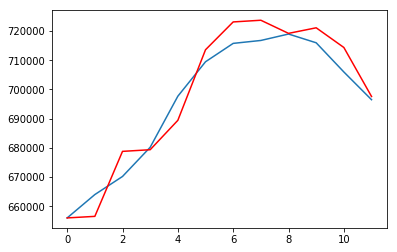

In [14]:
#Evaluate finalized model on validation dataset
from pandas import read_csv
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

#Load and prepare datasets
df=read_csv('/kaggle/input/apartment-benchmark-prices/Dataset.csv',index_col=0,header=0,squeeze=True)
X=df.values.astype('float32')
history=[x for x in X]
Validation=read_csv('/kaggle/input/apartment-benchmark-prices/Validation.csv',index_col=0,header=0,squeeze=True)
y=Validation.values.astype('float32')
model=ARIMA(X,order=(1,2,1))
model_fit=model.fit(disp=0)
bias=216
#Make first prediction
predictions=list()
yhat=bias+float(model_fit.forecast()[0])
predictions.append(y[0])
print('Predicted= %.4f, Expected= %.4f' % (yhat,y[0]))

#Rolling forecasts
for i in range(1,len(y)):
    #predict
    model=ARIMA(history,order=(1,2,0))
    model_fit=model.fit(disp=0)
    yhat=bias+float(model_fit.forecast()[0])
    predictions.append(yhat)
    #Observation
    obs=y[i]
    history.append(obs)
    print('Predicted= %.4f, Expected= %.4f' % (yhat,obs))
    
#Report performance
rmse=sqrt(mean_squared_error(y,predictions))
mape=mean_abs_percent_error(y,predictions)
print('')
print('RMSE: %.4f, Mean Absolute Percentage Error: %.4f' % (rmse,mape))
plt.plot(y)
plt.plot(predictions,color='red')
plt.show()


RMSE: 20538.6679, Mean Absolute Percentage Error: 1.7601


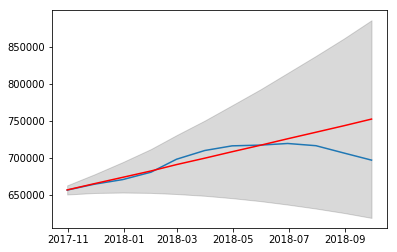

In [15]:
#Let's try the model's prediction power for 12-steps
#Load and prep data
import numpy as np
from datetime import datetime, timedelta

df=pd.read_csv('/kaggle/input/apartment-benchmark-prices/Dataset.csv',header=0,squeeze=True)
df.drop('Date',axis=1,inplace=True)
index=pd.date_range(start='2005',periods=153,freq='M')
df.index=index
X=df['Apartment']

Validation=pd.read_csv('/kaggle/input/apartment-benchmark-prices/Validation.csv',header=0,squeeze=True)
Validation.drop('Date',axis=1,inplace=True)
index2=pd.date_range(start='2017-10',periods=12,freq='M')
Validation.index=index2
y=Validation['Apartment']

#Direct forecast
mod1=ARIMA(X,order=(1,2,1),freq='M')
model_fit=mod1.fit()
fc,se,conf=model_fit.forecast(12,alpha=0.05)

#Turn into pandas Series
fc_series=pd.Series(fc,index=Validation.index)
lower_series=pd.Series(conf[:,0],index=Validation.index)
upper_series=pd.Series(conf[:,1],index=Validation.index)

#Get residuals
resid1=[y[i]-fc_series[i] for i in range(len(y))]


#Report performance
rmse=sqrt(mean_squared_error(y,fc_series))
mape=mean_abs_percent_error(y,fc_series)
print('RMSE: %.4f, Mean Absolute Percentage Error: %.4f' % (rmse,mape))

#Plot graph
plt.plot(y,label='Expected')
plt.plot(fc_series,label='Predicted',color='red')
plt.fill_between(lower_series.index,lower_series,upper_series,
                color='k',alpha=.15)
plt.show()



In [16]:
#How would an exponential smoothing model perform
#in comparison?

from statsmodels.tsa.holtwinters import ExponentialSmoothing

df=pd.read_csv('/kaggle/input/apartment-benchmark-prices/Dataset.csv',header=0,squeeze=True)
df.drop('Date',axis=1,inplace=True)
index=pd.date_range(start='2005',periods=153,freq='M')
df.index=index
X=df['Apartment']

#Split into train & test sets
X=X.astype('float32')
train_size=int(len(X)*0.7)
train, test=X[0:train_size], X[train_size:]

# Walk-forward validation
history=[x for x in train]
predictions=list()
for i in range(len(test)):
    #predict
    model=ExponentialSmoothing(history,trend='add',damped=True)
    model_fit=model.fit(remove_bias=True)
    yhat=model_fit.forecast()[0]
    predictions.append(yhat)
    #observation
    obs=test[i]
    history.append(obs)
    print('Predicted= %.4f, Expected= %.4f' % (yhat,obs))

# Report performance
rmse=sqrt(mean_squared_error(test,predictions))
print('RMSE: %.4f' % (rmse))


Predicted= 381981.5832, Expected= 380300.0000
Predicted= 380241.3517, Expected= 384000.0000
Predicted= 386145.0508, Expected= 387800.0000
Predicted= 391090.5092, Expected= 389800.0000
Predicted= 392180.3134, Expected= 390000.0000


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Predicted= 390805.1070, Expected= 392000.0000
Predicted= 393368.1949, Expected= 392800.0000
Predicted= 393919.4468, Expected= 391000.0000
Predicted= 390395.3307, Expected= 393800.0000
Predicted= 395168.5782, Expected= 393300.0000
Predicted= 393864.7216, Expected= 394800.0000
Predicted= 395830.3255, Expected= 394300.0000
Predicted= 394551.8617, Expected= 395800.0000
Predicted= 396773.0065, Expected= 395800.0000
Predicted= 396350.9719, Expected= 398800.0000
Predicted= 400768.6322, Expected= 404000.0000
Predicted= 407930.9269, Expected= 408500.0000
Predicted= 412637.3788, Expected= 411800.0000
Predicted= 415069.5030, Expected= 415000.0000
Predicted= 417852.5090, Expected= 415300.0000
Predicted= 416436.3299, Expected= 419500.0000
Predicted= 422195.3780, Expected= 428800.0000


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Predicted= 435332.2746, Expected= 437300.0000
Predicted= 444896.5776, Expected= 446100.0000


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Predicted= 453704.2318, Expected= 448100.0000
Predicted= 451361.6098, Expected= 457600.0000
Predicted= 463776.0710, Expected= 471100.0000
Predicted= 481784.9381, Expected= 479600.0000


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Predicted= 488244.9075, Expected= 492600.0000
Predicted= 503176.1034, Expected= 504100.0000
Predicted= 514744.4225, Expected= 521400.0000
Predicted= 535382.2157, Expected= 531400.0000
Predicted= 542366.8651, Expected= 536400.0000
Predicted= 542424.4080, Expected= 534400.0000
Predicted= 534342.3983, Expected= 533900.0000
Predicted= 533254.7038, Expected= 534600.0000
Predicted= 535210.1719, Expected= 532400.0000


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Predicted= 531508.6516, Expected= 534400.0000
Predicted= 535533.6832, Expected= 549900.0000


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Predicted= 561008.6345, Expected= 563600.0000
Predicted= 575876.0001, Expected= 580700.0000
Predicted= 594958.4290, Expected= 597400.0000
Predicted= 612636.1165, Expected= 614200.0000
Predicted= 629423.5152, Expected= 629900.0000
Predicted= 644296.7923, Expected= 639400.0000
Predicted= 648941.5934, Expected= 647700.0000
RMSE: 4002.7327


RMSE: 18705.5513, Mean Absolute Percentage Error: 2.0939


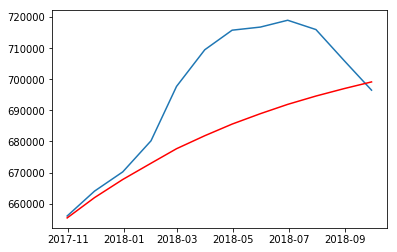

In [17]:
#Let's try the exponential smoothing 
#model's prediction power for 12-steps
#Load and prep data
import numpy as np
from datetime import datetime, timedelta

df=pd.read_csv('/kaggle/input/apartment-benchmark-prices/Dataset.csv',header=0,squeeze=True)
df.drop('Date',axis=1,inplace=True)
index=pd.date_range(start='2005',periods=153,freq='M')
df.index=index
X=df['Apartment']

Validation=pd.read_csv('/kaggle/input/apartment-benchmark-prices/Validation.csv',header=0,squeeze=True)
Validation.drop('Date',axis=1,inplace=True)
index2=pd.date_range(start='2017-10',periods=12,freq='M')
Validation.index=index2
y=Validation['Apartment']

#Direct forecast
mod2=ExponentialSmoothing(X,trend='add',damped=True,freq='M')
model_fit=mod2.fit(remove_bias=True)
fc=model_fit.forecast(12)

#Get residuals
resid2=[y[i]-fc[i] for i in range(len(y))]


#Report performance
rmse=sqrt(mean_squared_error(y,fc))
mape=mean_abs_percent_error(y,fc)
print('RMSE: %.4f, Mean Absolute Percentage Error: %.4f' % (rmse,mape))

#Plot graph
plt.plot(y,label='Expected')
plt.plot(fc,label='Predicted',color='red')
plt.show()


RMSE: 13699.6438, Mean Absolute Percentage Error: 1.4939


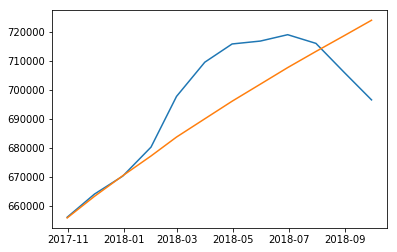

In [18]:
#Blending the forecasts from 
#ARIMA and ETS models.
#Weights using RMSE

Blend_fc=(0.47*fc_series+0.53*fc)

#Report performance
rmse=sqrt(mean_squared_error(y,Blend_fc))
mape=mean_abs_percent_error(y,Blend_fc)
print('RMSE: %.4f, Mean Absolute Percentage Error: %.4f' % (rmse,mape))

#Plot graph
plt.plot(y,label='Expected')
plt.plot(Blend_fc,label='Predicted')
plt.show()

In [19]:
#OK! Let's try and forecast for the 12 months
#from Sep 2018 and see what we get.

forecast_index=pd.date_range(start='2018-10',periods=12,freq='M')

#stick validation data to the dataset to train.
df1=df.append(Validation)
X=df1['Apartment']

#retrain mod1 and mod2 on df1
#Direct forecast
mod1=ARIMA(X,order=(1,2,1),freq='M')
model_fit=mod1.fit()
fc,se,conf=model_fit.forecast(12,alpha=0.05)

#Turn into pandas Series
fc_series=pd.Series(fc,index=forecast_index)
lower_series=pd.Series(conf[:,0],index=forecast_index)
upper_series=pd.Series(conf[:,1],index=forecast_index)

mod2=ExponentialSmoothing(X,trend='add',damped=True,freq='M')
model_fit=mod2.fit(remove_bias=True)
fc=model_fit.forecast(12)

#Blending the forecasts from 
#ARIMA and ETS models.
#Weights using RMSE

forecast=0.47*fc_series+0.53*fc

In [20]:
#Import actuals for Oct 2018 ~ Sep 2019
#https://www.crea.ca/housing-market-stats/mls-home-price-index/hpi-tool/
actuals=[693200,677500,675200,670200,671500,667500,667500,664200,654700,653200,654000,651500]
y=pd.Series(actuals,index=forecast_index)

RMSE: 22486.8870 Mean Absolute Percent Error: 2.8747


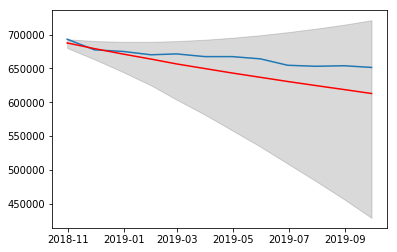

In [21]:
#Report performance
rmse=sqrt(mean_squared_error(y,forecast))
mape=mean_abs_percent_error(y,forecast)
print('RMSE: %.4f Mean Absolute Percent Error: %.4f' % (rmse,mape))

#Plot graph
plt.plot(y,label='Expected')
plt.plot(forecast,label='Predicted',color='red')
plt.fill_between(lower_series.index,lower_series,upper_series,
                color='k',alpha=.15)
plt.show()
